### IMPLEMENTATION

In [14]:
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler

class NeuralNet:
    def __init__(self, layers, epochs, lr, momentum, function, perc_validation):
        self.L = len(layers)    #Number of layers
        self.n = layers.copy()  #An array with the number of units in each layer

        self.h = []             #An array of arrays for the fields (h)
        for lay in range(self.L):
            self.h.append(np.zeros(layers[lay]))
        self.xi = []            #An array of arrays for the activations(Xi)
        for lay in range(self.L):
            self.xi.append(np.zeros(layers[lay]))

        self.w = []             #An array of matrices for the weights
        self.w.append(np.zeros((1, 1)))
        for lay in range(1, self.L):
            self.w.append(np.zeros((layers[lay], layers[lay - 1])))

        self.theta = []         #An array of arrays for thresholds
        for lay in range(self.L):
            self.theta.append(np.zeros(layers[lay]))
        
        self.delta = []         #An array of arrays for the propagation errors
        for lay in range(self.L):
            self.delta.append(np.zeros(layers[lay]))
            
        self.d_w = []           #An array of matrices for the changes on weights
        self.d_w.append(np.zeros((1, 1)))
        for lay in range(1, self.L):
            self.d_w.append(np.zeros((layers[lay], layers[lay - 1])))
        
        self.d_theta = []       #An array of arrays for the changes on thresholds
        for lay in range(self.L):
            self.d_theta.append(np.zeros(layers[lay]))
            
        self.d_w_prev = []      #An array of matrices for the previoius changes of the 
                                #weights used for the momentum term
        self.d_w_prev.append(np.zeros((1, 1)))
        for lay in range(1, self.L):
            self.d_w_prev.append(np.zeros((layers[lay], layers[lay - 1])))
            
        self.d_theta_prev = []  #An array of arrays for the previous changes of the 
                                #thresholds used for the momentum term
        for lay in range(self.L):
            self.d_theta_prev.append(np.zeros(layers[lay]))                     
        
        self.fact = function      #The name of the activation function that will be 
                                #used (sigmoid, relu, linear, tanh)
        
        self.epochs = epochs
        self.lr = lr
        self.momentum = momentum
        self.perc_validation = perc_validation
        
        self.train_errors = []
        self.val_errors = []
                                
    def _activation(self, x):
        if self.fact == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.fact == 'tanh':
            return np.tanh(x)
        elif self.fact == 'relu':
            return np.maximum(0, x)
        elif self.fact == 'linear':
            return x
        else:
            raise ValueError(f"Function {self.fact} not supported")

    def _activation_derivative(self, x):
        if self.fact == 'sigmoid':
            s = self._activation(x)
            return s * (1 - s)
        elif self.fact == 'tanh':
            s = self._activation(x)
            return 1 - s**2
        elif self.fact == 'relu':
            return (x > 0).astype(float)
        elif self.fact == 'linear':
            return np.ones_like(x)
        else:
            raise ValueError(f"Función {self.fact} no soportada")

    def initialize_w_theta(self):
        for L in range(1, self.L):
            # Inicializa pesos (w) y umbrales (theta) uniformemente entre -1 y 1.
            self.w[L] = np.random.uniform(-1.0, 1.0, size=(self.n[L], self.n[L - 1]))
            self.theta[L] = np.random.uniform(-1.0, 1.0, size=self.n[L])
    
    def feed_forward(self, X):
        self.xi[0] = X
        for L in range(1, self.L):
            # h[L] = w[L] * xi[L-1] - theta[L]
            self.h[L] = self.w[L].dot(self.xi[L-1]) - self.theta[L]

            # xi[L] = f(h[L])
            self.xi[L] = self._activation(self.h[L])

        return self.xi[self.L - 1]
        
    def activation_function(self, i, L):
        self.h[L][i] = 0
        for j in range(0, self.n[L-1]):
            self.h[L][i] += self.w[L][i, j] * self.xi[L-1][j]
            
        self.h[L][i] -= self.theta[L][i]
         
        return self._activation(self.h[L][i])
        #return (1 / (1 + np.exp(-self.h[L][i])))
    
    def error_back_propagation(self, out_x, y):

        L = self.L - 1
        # Capa de salida (vectorizado, correcto)
        self.delta[L] = (out_x - y) * self._activation_derivative(self.h[L])
        # Capas ocultas (también vectorizado)
        for l in range(self.L - 2, 0, -1):
            self.delta[l] = self._activation_derivative(self.h[l]) * (self.w[l+1].T.dot(self.delta[l+1]))
                 
    def update_values(self):
        for l in range(1, self.L):
            dw_gradiente = np.outer(self.delta[l], self.xi[l-1])
            
            self.d_w[l] = (-self.lr * dw_gradiente) + (self.momentum * self.d_w_prev[l])
            
            self.w[l] += self.d_w[l]
            
            self.d_theta[l] = (self.lr * self.delta[l]) + (self.momentum * self.d_theta_prev[l])
            self.theta[l] += self.d_theta[l]
            
        self.d_w_prev = [dw.copy() for dw in self.d_w]
        self.d_theta_prev = [dt.copy() for dt in self.d_theta]

    def shuffle_data(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values
        if y.ndim == 1:
            y = y.reshape(-1, 1)
            
        indices = np.random.permutation(X.shape[0])
        return X[indices], y[indices]

    def data_division(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        n_total = X.shape[0]
        n_test = int(0.20 * n_total)

        X_test = X[-n_test:]
        y_test = y[-n_test:]

        X_train_val = X[:-n_test]
        y_train_val = y[:-n_test]
        
        n_train_val = X_train_val.shape[0]
        n_val = int(self.perc_validation * n_train_val)

        X_val = X_train_val[:n_val]
        y_val = y_train_val[:n_val]

        X_train = X_train_val[n_val:]
        y_train = y_train_val[n_val:]
        
        self.X_train, self.y_train = X_train, y_train
        self.X_val,   self.y_val   = X_val,   y_val
        self.X_test,  self.y_test  = X_test,  y_test

        print("Shuffle y splits realizados:")
        print(f"  Train: {X_train.shape[0]} patrones")
        print(f"  Val:   {X_val.shape[0]} patrones")
        print(f"  Test:  {X_test.shape[0]} patrones")
    
    def calculate_quadratic_error(self, X_set, y_set):
        total_error = 0.0
        num_patterns = X_set.shape[0]

        for mu in range(num_patterns):
            x_mu = X_set[mu]
            z_mu = y_set[mu]

            # 1. Feed-forward: Obtener la predicción o(x^mu)
            o_mu = self.feed_forward(x_mu)

            squared_difference = (o_mu - z_mu)**2
            pattern_error_sum = np.sum(squared_difference) 
            
            total_error += pattern_error_sum

        return 0.5 * total_error
    
    def fit(self,X,y):
        
        self.initialize_w_theta()
        X, y = self.shuffle_data(X, y)
        self.data_division(X, y)
        num_train = self.X_train.shape[0]
        val_err = np.nan
        
        for epoch in range(self.epochs):
            for _ in range(num_train):
                idx = np.random.randint(0, num_train)   # patrón aleatorio
                #Choose a random pattern (xu zu) of training set
                output = self.feed_forward(self.X_train[idx])
                #print(f"Output {output}")
                
                #Back-propagate the error for this pattern
                self.error_back_propagation(output, self.y_train[idx])
                
                #Update the weights and threseholds
                self.update_values()
            
            train_err = self.calculate_quadratic_error(self.X_train, self.y_train)
            self.train_errors.append(train_err)
            
            if self.perc_validation > 0:
                val_err = self.calculate_quadratic_error(self.X_val, self.y_val)
                self.val_errors.append(val_err)
            
            print(f"Epoch {epoch}: Train Error={train_err:.4f}, Val Error={val_err:.4f}")
        
    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X, dtype=float)

        all_scaled_predictions = []
        X_input = X

        for idx, x in enumerate(X_input):
            
            scaled_prediction = self.feed_forward(x) 
            all_scaled_predictions.append(scaled_prediction[0])
            
        scaled_predictions_array = np.array(all_scaled_predictions).reshape(-1, 1)
        
        return scaled_predictions_array
    
    def loss_epochs(self):
        return np.array(self.train_errors), np.array(self.val_errors)


### TEST

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import Index
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
df = pd.read_csv("proccesed.csv")

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['price', 'log_price'], errors='ignore')
scaler = MinMaxScaler(feature_range=(0, 1))
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
y_scaler = MinMaxScaler(feature_range=(0,1))
df["log_price"] = y_scaler.fit_transform(df["log_price"].values.reshape(-1,1))

In [17]:
top_features = Index(['sqft_living', 'city_Seattle', 'sqft_lot', 'sqft_above',
       'city_Bellevue', 'yr_built', 'house_age', 'bathrooms', 'city_Redmond',
       'since_renovation', 'city_Auburn', 'city_Kirkland', 'statezip_WA 98178',
       'view', 'city_Kent', 'city_Federal Way', 'city_Issaquah', 'bedrooms',
       'city_Renton', 'sqft_basement'],
      dtype='object')

In [18]:

# Selección de 500 filas aleatorias
X = df.drop(columns=["log_price", "price"], axis=1)
y = df["log_price"]

X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)

X = X[top_features]

# Reducimos a 500 filas
#X = X.sample(n=500, random_state=42)
#y = y.loc[X.index]
y = y.values.reshape(-1, 1)

In [31]:
net = NeuralNet(
    layers=[20, 64, 32, 16, 1],
    epochs=50,
    lr=0.005,
    momentum=0.2,
    function='tanh',
    perc_validation=0.5,
)

net.fit(X, y)

Shuffle y splits realizados:
  Train: 1552 patrones
  Val:   1551 patrones
  Test:  775 patrones
Epoch 0: Train Error=34.9625, Val Error=39.7067
Epoch 1: Train Error=20.2173, Val Error=25.3175
Epoch 2: Train Error=15.9636, Val Error=19.6370
Epoch 3: Train Error=13.5561, Val Error=16.3942
Epoch 4: Train Error=12.6886, Val Error=15.6216
Epoch 5: Train Error=11.7150, Val Error=13.4655
Epoch 6: Train Error=10.9223, Val Error=12.7401
Epoch 7: Train Error=10.3548, Val Error=12.5429
Epoch 8: Train Error=9.8724, Val Error=11.8836
Epoch 9: Train Error=9.5469, Val Error=11.2216
Epoch 10: Train Error=9.5196, Val Error=10.9959
Epoch 11: Train Error=9.2109, Val Error=10.9765
Epoch 12: Train Error=9.2899, Val Error=10.6687
Epoch 13: Train Error=8.8016, Val Error=10.2147
Epoch 14: Train Error=8.7517, Val Error=10.0726
Epoch 15: Train Error=8.4842, Val Error=9.9137
Epoch 16: Train Error=8.9727, Val Error=10.7839
Epoch 17: Train Error=8.2487, Val Error=9.7719
Epoch 18: Train Error=8.4045, Val Error=9.9

In [32]:
# 1. Predicciones en escala 0–1
predictions = net.predict(net.X_test)
preds_scaled = predictions.reshape(-1, 1)

print("--- PREDICTIONS EN ESCALA DE 0-1 ---")
print(preds_scaled)

# 2. Desescalar log_price
pred_log_price = y_scaler.inverse_transform(preds_scaled)

print("--- PREDICCIONES DES-ESCALADAS (log_price) ---")
print(pred_log_price)

# 3. Obtener precio real
final_prices = np.exp(pred_log_price)

print("--- PRECIOS FINALES ---")
print(final_prices)

--- PREDICTIONS EN ESCALA DE 0-1 ---
[[ 0.66934573]
 [ 0.61466025]
 [ 0.50065694]
 [ 0.53237324]
 [ 0.63398395]
 [ 0.52300123]
 [ 0.46075956]
 [ 0.61113935]
 [ 0.55412422]
 [ 0.66740889]
 [ 0.33456777]
 [ 0.60019713]
 [ 0.61200353]
 [ 0.47188721]
 [ 0.41687444]
 [ 0.69564661]
 [ 0.53551748]
 [ 0.27293969]
 [ 0.52607044]
 [ 0.77473898]
 [ 0.48210272]
 [ 0.49173145]
 [ 0.44601852]
 [ 0.39955784]
 [ 0.51235733]
 [ 0.62056128]
 [ 0.58254452]
 [ 0.4391275 ]
 [ 0.20481466]
 [ 0.32741007]
 [ 0.44495718]
 [ 0.53911901]
 [ 0.35255155]
 [ 0.52597909]
 [ 0.65610295]
 [ 0.26093697]
 [ 0.43257997]
 [ 0.62532417]
 [ 0.63065311]
 [ 0.28674629]
 [ 0.38211635]
 [ 0.33868777]
 [ 0.40183717]
 [ 0.26684811]
 [ 0.54199963]
 [ 0.50770047]
 [ 0.50360096]
 [ 0.56167283]
 [ 0.3682299 ]
 [ 0.39538921]
 [ 0.47511972]
 [ 0.45401161]
 [ 0.48067078]
 [ 0.64020063]
 [ 0.52609631]
 [ 0.36602741]
 [ 0.50403464]
 [ 0.24975396]
 [ 0.56963489]
 [ 0.62323024]
 [ 0.66354638]
 [ 0.59797874]
 [ 0.61839824]
 [ 0.75414458]
 [ 

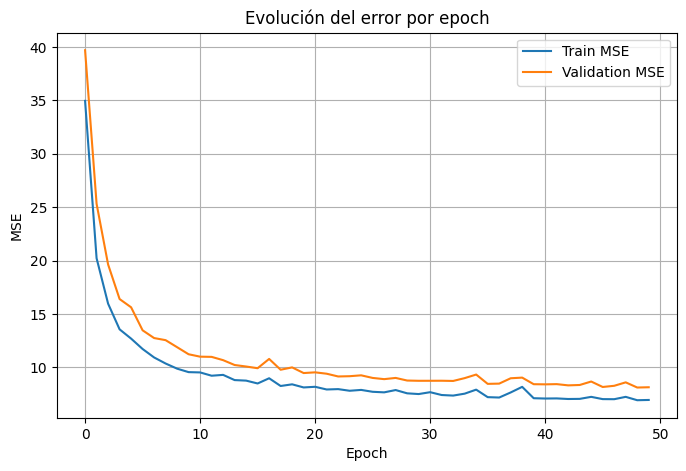

In [33]:
train_errors, val_errors = net.loss_epochs()
plt.figure(figsize=(8,5))
plt.plot(train_errors, label="Train MSE")
if net.X_val.shape[0] > 0:
    plt.plot([e for e in val_errors if e is not None], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Evolución del error por epoch")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
def mean_squared_error(y_true, y_pred):
    """Calcula el Error Cuadrático Medio (MSE)."""
    return np.mean((y_true - y_pred)**2)

def mean_absolute_error(y_true, y_pred):
    """Calcula el Error Absoluto Medio (MAE)."""
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Error Absoluto Porcentual Medio (MAPE)."""
    # Se usa np.clip para evitar la división por cero si y_true es 0
    y_true_clipped = np.clip(y_true, a_min=1e-8, a_max=None)
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true_clipped))

In [35]:
y_test_log = net.y_test.reshape(-1, 1)
y_test_log = y_scaler.inverse_transform(y_test_log) 

y_test_original = np.exp(y_test_log)


print("\n--- MÉTRICAS DE EVALUACIÓN FINAL (PRECIO ORIGINAL) ---")

mse = mean_squared_error(y_test_original, final_prices)
print(f"MSE (Mean Squared Error): {mse:.2f}")

mae = mean_absolute_error(y_test_original, final_prices)
print(f"MAE (Mean Absolute Error): {mae:.2f}")

mape = mean_absolute_percentage_error(y_test_original, final_prices)
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

r2 = r2_score(y_test_original, final_prices)
print(f"R2 (Coefficient of Determination): {r2:.4f}")


--- MÉTRICAS DE EVALUACIÓN FINAL (PRECIO ORIGINAL) ---
MSE (Mean Squared Error): 31094898287.20
MAE (Mean Absolute Error): 114122.84
MAPE (Mean Absolute Percentage Error): 23.99%
R2 (Coefficient of Determination): 0.5801
